# Problem statment 

Consider a 100-gon where 10 vertices are colored 1 and
the rest are colored 0 according to the following rules: 

* Class 1 consists of two groups of 5 contiguous vertices colored 1.
* Class 2 consists of two groups of 6 and 4 contiguous vertices, respectively, colored 1.


## sampling toy data

We sample equally from the distributions described above and futher divide them 50/50 into training and testing sets. 


In [7]:
import time
#import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

import rerf
from rerf.rerfClassifier import rerfClassifier

import pickle

In [3]:
def samp(n1,n2):
    n1,n2 = int(n1),int(n2)
    X1 = np.empty((n1,100))
    Y1 = np.full(n1,0)
    for i in range(n1):        
        cir = np.zeros(100)
        
        s1 = np.random.choice(range(0,100))        
        l1 = [j%100 for j in range(s1,s1+5)]
        
        exclude_idx = set(l1).union(set([j%100 for j in range(s1-4,s1)]))
        s2 = np.random.choice(list(set(range(0,100)).difference(exclude_idx)))
        l2 = [j%100 for j in set(range(s2,s2+5)).difference(set(l1))]
        
        cir[l1] = 1
        cir[l2] = 1
        
        X1[i] = cir
        
    X2 = np.empty((n2,100))
    Y2 = np.full(n2,1)
    for i in range(n2):        
        cir = np.zeros(100)
        
        s1 = np.random.choice(range(0,100))        
        l1 = [j%100 for j in range(s1,s1+4)]
        
        exclude_idx = set(l1).union(set([j%100 for j in range(s1-5,s1)]))
        s2 = np.random.choice(list(set(range(0,100)).difference(exclude_idx)))
        l2 = [j%100 for j in set(range(s2,s2+6)).difference(set(l1))]
        
        cir[l1] = 1
        cir[l2] = 1
        
        X2[i] = cir
        
    return((np.vstack([X1,X2]),np.hstack([Y1,Y2])))

In [8]:
np.random.seed(1234)
n = 0.5 * np.array([400,800,2000,4000])
n1 = n
n2 = n
TRAIN_FRAC = 0.5
n1_train, n2_train = n1*TRAIN_FRAC, n2*TRAIN_FRAC
n1_test, n2_test = n1*(1-TRAIN_FRAC), n2*(1-TRAIN_FRAC)

In [11]:
X_train = []
Y_train = []
for i1,i2 in zip(n1_train,n2_train):
    x_train,y_train = samp(i1,i2)
    shuffled_idx = list(range(len(y_train))); np.random.shuffle(shuffled_idx)
    X_train.append(x_train[shuffled_idx])
    Y_train.append(y_train[shuffled_idx])

In [12]:
X_test = []
Y_test = []
for i1,i2 in zip(n1_test,n2_test):
    x_test,y_test = samp(i1,i2)
    shuffled_idx = list(range(len(y_test))); np.random.shuffle(shuffled_idx)
    X_test.append(x_test[shuffled_idx])
    Y_test.append(y_test[shuffled_idx])

# Running R-Rerf

We have created samples and will run structured
random forest on half and test on the rest. 

In [13]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
from sklearn.model_selection import GridSearchCV
import time

### S-Rerf Results

In [15]:
max_features = [1,5] + [i for i in range(20,101,20)] # (d) the number features to consider for best split
image_width = 100 # iw
image_height = 1 # ih
patch_max = np.arange(2,16) # pm, the patch max size
patch_min = 1

In [18]:
## S-Rerf Parameter Search
parameters = {'max_features':max_features,
                  'patch_width_max':patch_max}

clf_s_rerf = rerfClassifier(projection_matrix="S-RerF",
                            n_estimators=100,
                            oob_score=True,
                            random_state=1,
                            **{'image_height':image_height,
                              'image_width':image_width,
                              'patch_height_max':image_height,
                              'patch_height_min':patch_min,
                              'patch_width_min':patch_min}
                            )
gs_s_rerf = GridSearchCV(clf_s_rerf, parameters, cv=5)

t0 = time.time()
gs_s_rerf.fit(X_train[1],Y_train[1])
run_time = time.time() - t0

print('Run time:', run_time)
print("Best Params:", gs_s_rerf.best_params_)

Run time: 1925.0597319602966
Best Params: {'max_features': 40, 'patch_width_max': 15}


In [19]:
rerf_train_errs = np.empty(len(X_train))
rerf_test_errs = np.empty(len(X_train))
for i in range(len(X_train)):
    clf_s_rerf = rerfClassifier(projection_matrix="S-RerF",
                                    n_estimators=100,
                                    oob_score=True,
                                    random_state=1,
                                    **{'image_height':image_height,
                                      'image_width':image_width,
                                      'patch_height_max':image_height,
                                      'patch_height_min':patch_min,
                                      'patch_width_min':patch_min},
                                    **gs_s_rerf.best_params_
                                   )
    
    clf_s_rerf.fit(X_train[i],Y_train[i])
    rerf_train_errs[i] = clf_s_rerf.score(X_train[i],Y_train[i])
    rerf_test_errs[i] = clf_s_rerf.score(X_test[i],Y_test[i])

### RF Results

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
## RF Parameter Search

parameters = {'max_features':max_features}

clf_rf = RandomForestClassifier(n_estimators=100,
                             random_state=1)

gs_rf = GridSearchCV(clf_rf, parameters, cv=5)

t0 = time.time()
gs_rf.fit(X_train[1],Y_train[1])
run_time = time.time() - t0

print('Run time:', run_time)
print("Best Params:", gs_rf.best_params_)

Run time: 8.655664682388306
Best Params: {'max_features': 100}


In [22]:
rf_train_errs = np.empty(len(X_train))
rf_test_errs = np.empty(len(X_train))
for i in range(len(X_train)):
    clf_rf = RandomForestClassifier(n_estimators=100,
                                    random_state=1,
                                    **gs_rf.best_params_)
                                    
    clf_rf.fit(X_train[i],Y_train[i])
    train_error = clf_rf.score(X_train[i],Y_train[i])
    test_error = clf_rf.score(X_test[i],Y_test[i])

    rf_train_errs[i] = train_error
    rf_test_errs[i] = test_error

### SVM Results

In [30]:
from sklearn.svm import SVC

In [32]:
## SVM Parameter Search

Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1, 10]
parameters = {'C': Cs, 'gamma' : gammas}

clf_svc = SVC(kernel='rbf',random_state=1)

gs_svc = GridSearchCV(clf_svc, parameters, cv=5)

t0 = time.time()
gs_svc.fit(X_train[1],Y_train[1])
run_time = time.time() - t0

print('Run time:', run_time)
print("Best Params:", gs_svc.best_params_)

Run time: 21.393981456756592
Best Params: {'C': 0.0001, 'gamma': 1}


In [34]:
svc_train_errs = np.empty(len(X_train))
svc_test_errs = np.empty(len(X_train))
for i in range(len(X_train)):
    clf_svc = SVC(kernel='rbf',
                   random_state=1,
                   **gs_svc.best_params_)
                                    
    clf_svc.fit(X_train[i],Y_train[i])
    train_error = clf_svc.score(X_train[i],Y_train[i])
    test_error = clf_svc.score(X_test[i],Y_test[i])

    svc_train_errs[i] = train_error
    svc_test_errs[i] = test_error

### Plot Results

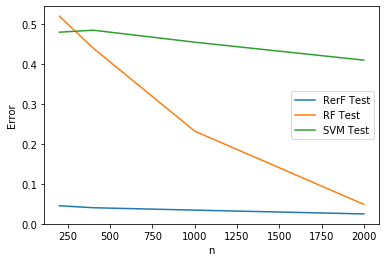

In [37]:
#plt.plot(c1_train + c2_train, 1-train_errs)
plt.plot(c1_train + c2_train, 1-test_errs)

#plt.plot(c1_train + c2_train, 1-rf_train_errs)
plt.plot(c1_train + c2_train, 1-rf_test_errs)

plt.plot(c1_train + c2_train, 1-svc_test_errs)

plt.title('Circle experiment test data error rates')
plt.xlabel('n')
plt.ylabel('Error')
#plt.legend(['RerF Train','RerF Test','RF Train','RF Test'],loc='best')
plt.legend(['RerF','RF','SVM'],loc='best')

## Full